In [1]:
import time
import sys
sys.path.insert(0, '../../../src/helper')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import IFrame

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import zbp_visualizer

In [2]:
SEED = 42

# DATA INGESTION

In [3]:
file_path = '../../../src/data/temp/lagged_zbp_totals_with_features.csv'
data = pd.read_csv(file_path)
data.head()

,zip,year,est,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,naics_11_pct,...,n50_99_pct,n100_249_pct,n250_499_pct,n500_999_pct,n1000_pct,median_hh_income,total_population,total_retirement,total_midcareer (25-34),total_midcareer (35-44)
0,91901,2013,402,H,4141.0,H,36304.0,H,174786.0,0.000000,...,0.010230,0.005115,0.002558,0.000000,0.002558,76496.0,17034.0,2691.0,1441.0,2011.0
1,91901,2014,392,H,4808.0,H,54568.0,H,188411.0,0.000000,...,0.012438,0.007463,0.000000,0.002488,0.002488,79792.0,17123.0,2678.0,1693.0,1786.0
2,91901,2015,397,H,4436.0,H,45258.0,H,171382.0,0.002551,...,0.012755,0.010204,0.000000,0.000000,0.002551,81379.0,18184.0,3075.0,1989.0,1598.0
3,91901,2016,390,H,4255.0,H,37704.0,H,151533.0,0.000000,...,0.012594,0.005038,0.000000,0.000000,0.002519,79859.0,18507.0,3158.0,1947.0,1683.0
4,91901,2017,413,H,4515.0,H,39556.0,H,167307.0,0.000000,...,0.015385,0.010256,0.000000,0.000000,0.002564,81603.0,18586.0,3236.0,1771.0,1909.0


# CUSTOM TSCV

In [4]:
class CustomTimeSeriesSplit:
    def __init__(self, n_splits=None):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        
        year_range = np.sort(X['year'].unique())
        min_year = year_range[0]
        
        self.n_splits = len(year_range) - 1
        
        for test_year in year_range[1:]:
            curr_range = np.arange(min_year, test_year)
            train = X[X['year'].apply(lambda year: year in curr_range)].index.to_numpy()
            test = X[X['year'] == test_year].index.to_numpy()
            
            yield train, test

    def get_n_splits(self, X, y, groups=None):
        
        year_range = np.sort(X['year'].unique())
        
        return len(year_range) - 1

# TRAIN-TEST SPLIT

In [5]:
tscv = CustomTimeSeriesSplit()
split = list(tscv.split(data, None))

train_indicies, test_indicies = split[-1]

data_train = data.iloc[train_indicies].reset_index(drop=True)
data_test = data.iloc[test_indicies].reset_index(drop=True)


# MODEL

In [6]:
preproc = ColumnTransformer([('onehots', OneHotEncoder(handle_unknown='ignore'), ['zip'])]
                             ,remainder = 'passthrough')
pl = Pipeline(steps=[('preproc', preproc), ('reg', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [7]:
%%time

included_feats = data.columns.drop(['est', 'emp_nf', 'qp1_nf', 'ap_nf'])
# included_feats = ['zip', 'year', 'naics_62_pct', 'total_retirement', 'total_population', 'naics_81_pct', 'ap', 'n1_4_pct', 'naics_23_pct', 'naics_54_pct']

param_grid = {'reg__n_estimators': [50],
              'reg__max_depth': [50]}

grid_search = GridSearchCV(estimator = pl, param_grid = param_grid, cv = CustomTimeSeriesSplit(), scoring = 'neg_root_mean_squared_error', n_jobs = -1)

X_train = data_train[included_feats]
y_train = data_train['est']

grid_search.fit(X_train, y_train)

display(grid_search.best_params_)
display(grid_search.best_score_)

{'reg__max_depth': 50, 'reg__n_estimators': 50}

-124.3291183718602

CPU times: total: 3.52 s
Wall time: 2.74 s


# TESTING

In [8]:
X_test = data_test[included_feats]
y_test = data_test['est']

In [9]:
reg = grid_search.best_estimator_

y_preds = reg.predict(X_train)
display(mean_squared_error(y_train, y_preds, squared=False))

y_preds = reg.predict(X_test)
display(mean_squared_error(y_test, y_preds, squared=False))

792.402261702128

6316.647969230768

# FEATURE IMPORTANCE - BY MEAN DECREASE IN IMPURITY

array(['naics_62_pct', 'total_retirement', 'total_population',
       'naics_81_pct', 'ap', 'zip_92024', 'n1_4_pct', 'naics_23_pct',
       'zip_92101', 'naics_54_pct'], dtype=object)

Text(0.5, 0, 'Mean decrease in impurity')

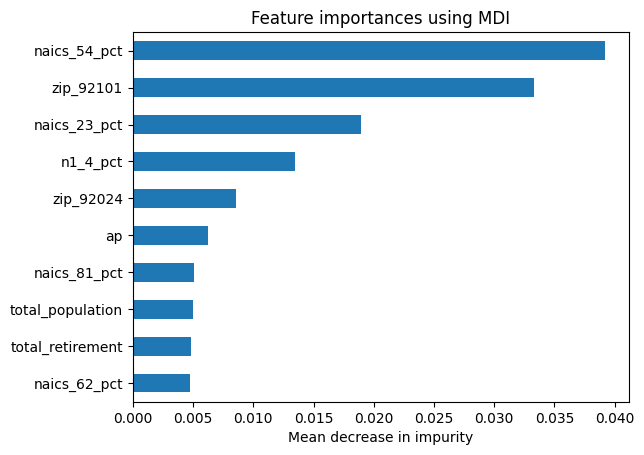

In [10]:
top_x = 11

preproc.fit(X_train)
feature_names = preproc.get_feature_names_out()
feature_names = np.char.replace(feature_names.astype('str'), 'onehots__','')
feature_names = np.char.replace(feature_names, 'remainder__','')


importances = reg['reg'].feature_importances_
std = np.std([tree.feature_importances_ for tree in reg['reg'].estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[1:top_x].sort_values(ascending=True)
display(forest_importances.index.to_numpy())

fig, ax = plt.subplots()
forest_importances.plot(kind='barh', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")

# VISUALIZE PREDICTIONS

In [ ]:
last_year = X_test['year'].unique()[0]

path_relative_to_root = '../../../'
plots_folder = 'out/plots/'
out_path = f'{path_relative_to_root}{plots_folder}zbp_plot_rf_reg_{last_year}_preds.html'

preds_last_year = pd.concat([X_test['zip'], pd.Series(y_preds)], axis=1).rename(columns={0:'est_pred'})
zbp_visualizer.generate_zbp_chloropleth(preds_last_year, 'zip', 'est_pred', out_path)

IFrame(out_path, 500,500)

# LONGSHOT PREDICTION ACCURACY EVALUATION

In [ ]:
num_years_in_training = 3
split_year = data['year'].unique().max() - num_years_in_training

data_train = data[data['year'] <= split_year]
data_test = data[data['year'] > split_year]

X_train = data_train[included_feats]
y_train = data_train['est']
X_test = data_test[included_feats]
y_test = data_test['est']

reg.fit(X_train, y_train)

y_preds = reg.predict(X_train)
display(mean_squared_error(y_train, y_preds, squared=False))

y_preds = reg.predict(X_test)
display(mean_squared_error(y_test, y_preds, squared=False))